In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models

from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import ImageEnhance
import itertools

from collections import Counter
import sys
import os
import random
from tqdm import tqdm
import intel_extension_for_pytorch as ipex

工业品组装缺陷类别划分
0 完整
1 图片缺角
2 缺一颗螺丝
3 缺临边两颗螺丝
4 缺三颗螺丝
5 缺四颗螺丝
6 缺对角两颗螺丝

In [74]:
# class Residual(nn.Module):
#     def __init__(self, input_channels, num_channels, use_conv=False, strides=1):
#         super().__init__()
#         self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
#         self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
#         if use_conv:
#             self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
#         else:
#             self.conv3 = None
#         self.bn1 = nn.BatchNorm2d(num_channels)
#         self.bn2 = nn.BatchNorm2d(num_channels)
    
#     def forward(self, X):
#         Y = F.relu(self.bn1(self.conv1(X)))
#         Y = self.bn2(self.conv2(Y))
#         if self.conv3:
#             X = self.conv3(X)
#         Y += X
#         return F.relu(Y)
# b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), 
#                    nn.BatchNorm2d(64), nn.ReLU(), 
#                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
#     blk = []
#     for i in range(num_residuals):
#         if i == 0 and not first_block:
#             blk.append(Residual(input_channels, num_channels, use_conv=True, strides=2))
#         else:
#             blk.append(Residual(num_channels, num_channels))
#     return blk

# b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
# b3 = nn.Sequential(*resnet_block(64, 128, 2))
# b4 = nn.Sequential(*resnet_block(128, 256, 2))
# b5 = nn.Sequential(*resnet_block(256, 512, 2))
# net = nn.Sequential(b1, b2, b3, b4, b5, 
#                     nn.AdaptiveAvgPool2d((1, 1)), 
#                     nn.Flatten(), nn.Linear(512, 10))

EPOCHS=50
modellr=1e-4
# 创建ResNet50模型实例
net = torchvision.models.resnet50(pretrained=True)

# 修改输入层
net.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)

# 修改输出层
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 7)
net = net.to('xpu')

optimizer=optim.Adam(net.parameters(),lr=modellr)
criterion=nn.CrossEntropyLoss()
net.train()
net,optimizer = ipex.optimize(net,optimizer=optimizer,dtype=torch.bfloat16)

RuntimeError: PyTorch is not linked with support for xpu devices

In [66]:
# 预处理数据
transformer = transforms.Compose([
    torchvision.transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化
])
data = pd.read_csv(r'./data.txt',sep='\t',header=None,names=None)
train_images_tensor = []
test_images_tensor = []
train_labels_tensor = []
test_labels_tensor = []
name0 = []
name1 = []
name2 = []
name3 = []
name4 = []
name5 = []
name6 = []
for i in data.iloc[:,0]:
    file_name = i.split(' ')[0]
    label = i.split(' ')[1]
    if label=='1':
        name1.append(file_name)
    elif label=='0':
        name0.append(file_name)
    elif label=='2':
        name2.append(file_name)
    elif label=='3':
        name3.append(file_name)
    elif label=='4':
        name4.append(file_name)
    elif label=='5':
        name5.append(file_name)
    else:
        name6.append(file_name)
random.shuffle(name0)
random.shuffle(name1)
random.shuffle(name2)
random.shuffle(name3)
random.shuffle(name4)
random.shuffle(name5)
random.shuffle(name6)
image_list = [name0,name1,name2,name3,name4,name5,name6]
for i in range(len(image_list)):
    for j in range(len(image_list[i])):
        image = Image.open(r'./defect_product/'+image_list[i][j]).convert('L')
        if j+1<=len(image_list[i])*0.7:
            tensor = transformer(image).type(torch.float32)
            train_images_tensor.append(tensor)
            label_tensor = torch.tensor(i)
            train_labels_tensor.append(label_tensor)
        else:
            tensor = transformer(image).type(torch.float32)
            test_images_tensor.append(tensor)
            label_tensor = torch.tensor(i)
            test_labels_tensor.append(label_tensor)
for m in range(len(image_list)):
    for k in range(len(image_list[m])):
        image = Image.open(r'./defect_product/'+image_list[m][k]).convert('L')
        if k+1<=len(image_list[m])*0.7:
            tensor = transformer(image).type(torch.float32)
            train_images_tensor.append(tensor)
            label_tensor = torch.tensor(m)
            train_labels_tensor.append(label_tensor)
        else:
            tensor = transformer(image).type(torch.float32)
            test_images_tensor.append(tensor)
            label_tensor = torch.tensor(m)
            test_labels_tensor.append(label_tensor)

torch.save(train_images_tensor, 'train_images_tensor.pt')
torch.save(test_images_tensor, 'test_images_tensor.pt')
torch.save(train_labels_tensor, 'train_labels_tensor.pt')
torch.save(test_labels_tensor, 'test_labels_tensor.pt')

In [67]:
# 加载tensor文件
train_images_tensor = torch.load('./train_images_tensor.pt')
test_images_tensor = torch.load('./test_images_tensor.pt')
train_labels_tensor = torch.load('./train_labels_tensor.pt')
test_labels_tensor = torch.load('./test_labels_tensor.pt')
train_datas_tensor = torch.stack(train_images_tensor)
train_labels_tensor = torch.stack(train_labels_tensor)
test_datas_tensor = torch.stack(test_images_tensor)
test_labels_tensor = torch.stack(test_labels_tensor)
train_dataset = TensorDataset(train_datas_tensor,train_labels_tensor)
train_dataloader = DataLoader(train_dataset,batch_size=2,shuffle=True)
test_dataset = TensorDataset(test_datas_tensor,test_labels_tensor)
test_dataloader = DataLoader(test_dataset,batch_size=2,shuffle=True)

In [29]:
# 定义损失函数和优化器
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [72]:
for epoch in range(1,EPOCHS+1):
    running_loss = 0.0
    num_images = 0
    loop = tqdm(enumerate(train_dataloader,0))
    for step,data in loop:
        labels,inputs = data[1],data[0]
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        num_images +=inputs.size(0)
        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch}/{EPOCHS}]')
        loop.set_postfix(loss=running_loss/(step+1))
print('Finish!!!')

Epoch [1/50]: : 79it [00:36,  2.18it/s, loss=1.86]
Epoch [2/50]: : 79it [00:35,  2.24it/s, loss=1.51]
Epoch [3/50]: : 79it [00:35,  2.22it/s, loss=1.28]
Epoch [4/50]: : 79it [00:37,  2.13it/s, loss=1]    
Epoch [5/50]: : 79it [00:35,  2.24it/s, loss=0.632]
Epoch [6/50]: : 79it [00:37,  2.12it/s, loss=0.517]
Epoch [7/50]: : 79it [00:34,  2.26it/s, loss=0.513]
Epoch [8/50]: : 79it [00:34,  2.27it/s, loss=0.61] 
Epoch [9/50]: : 77it [00:35,  2.17it/s, loss=0.531]


KeyboardInterrupt: 

In [69]:
torch.save(net.state_dict(),'./resnet_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [70]:
correct = 0
total = 0 
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0],data[1]
        outputs = net(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {100*correct/total:.2f}%')

Accuracy on test set: 39.47%


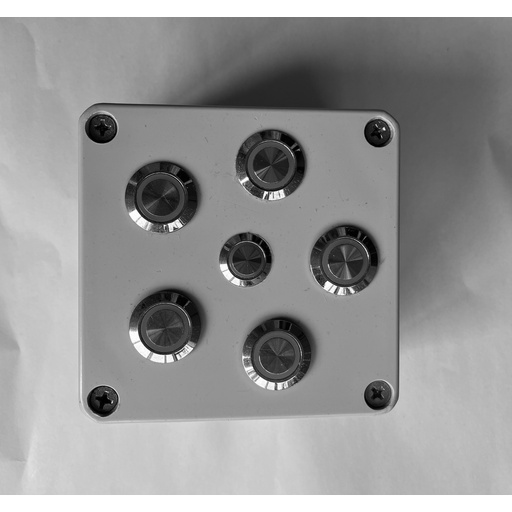

Predicted label: 1


In [24]:
# inference
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化
])
image = Image.open(r'./defect_product/119.JPG').convert('L')
image.show()
tensor = transformer(image).type(torch.float32).reshape(1,1,512,512)
with torch.no_grad():
    outputs = net(tensor)
    _,predicted = torch.max(outputs.data,1)
    print('Predicted label:',predicted.item())